<a href="https://colab.research.google.com/github/himanshu230998/CS504-project/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 : Working with Generative Adversarial Networks

---
##Name : Himanshu Kumar Singh
##Entry Number : 2017meb1212

Total Points: **100**

Tentative Weightage : **10%**

In [ ]:
#import
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import collections
import matplotlib.gridspec as gridspec
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow import keras
from tensorflow.keras import layers
random_seed = 100
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
params = dict(
    batch_size=256,
    z_dim=128,
    x_dim=2
)

##Given Ring Dataset

In [ ]:
#2D Ring Dataset
ds = tfp.distributions
def sample_ring(batch_size,train_test_ratio, n_mixture=8, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    points = [xs,ys]
    centers = np.stack(points,axis=1)
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    data = data.sample(batch_size)
    data = tf.random.shuffle(data)
    split_index= round(batch_size*train_test_ratio)
    return data[:split_index],data[split_index:],centers
train_ring_X, test_ring_X, centre_ring = sample_ring(params['batch_size'],0.8)


##Given Grid dataset

In [ ]:
def sample_grid(batch_size,train_test_ratio, n_mixture=25, std=0.01, radius=1.0):
    x_range = np.linspace(-1, 1, int(np.sqrt(n_mixture)))
    y_range = np.linspace(-1, 1, int(np.sqrt(n_mixture)))
    xx, yy = radius *x_range, radius * y_range
    xs = []
    ys = []
    for i in xx:
        for j in yy:
            xs.append(i)
            ys.append(j)
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    cat = ds.Categorical(tf.zeros(n_mixture))
    points = [xs,ys]
    centers = np.stack(points,axis=1)
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    data = data.sample(batch_size)
    data = tf.random.shuffle(data)
    split_index= round(batch_size*train_test_ratio)
    return data[:split_index],data[split_index:],centers

In this lab, you will be working with Generative Adversarial Networks (GANs) to learn the probability distribution of a few 2D toy datasets.
## GAN Variants
Implement the following GAN Variants which vary mainly in their loss functions:


*  Vanilla GAN minimizing the Jenson Shannon Divergence [1]




In [ ]:
#Generator for ring sample
generator_ring_model = keras.Sequential(
    [
        keras.Input(shape=(1,128)),
        layers.Dense(128,  activation='tanh'),
        layers.Dense(128, activation='tanh'),
        layers.Dense(2, activation='tanh'),        #LeakyReLU()
    ],name="generator_ring_model_v"
)
generator_ring_model.summary()

#Discriminator for ring sample
discriminator_ring_model = keras.Sequential(
    [
        keras.Input(shape=(1,2)),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(1, activation='tanh',use_bias=False),
    ],name="discriminator_ring_model_v"
)
discriminator_ring_model.summary()

#Generator for Grid sample
generator_grid_model = keras.Sequential(
    [
        keras.Input(shape=(1,128)),
        layers.Dense(128, input_shape=(256,128), activation='tanh'),
        layers.Dense(128, activation='tanh'),
        layers.Dense(2, activation='tanh'),
    ],name="generator_grid_model_v"
)
generator_grid_model.summary()

#Discriminator for ring sample
discriminator_grid_model = keras.Sequential(
    [
        keras.Input(shape=(1,2)),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(1, activation='tanh',use_bias=False),
    ],name="discriminator_grid_model_v"
)
discriminator_grid_model.summary()

class vgan:
    def __init__(self, generator_model, discriminator_model):
        self.generator_model = generator_model
        self.discriminator_model = discriminator_model
    def generator_loss(self,z):
        x = self.generator_model(z, training=True)
        fake_score = self.discriminator_model(x, training=True)
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_score),logits=fake_score))
        return loss

    def discriminator_loss(self,x,z):
        x_fake = self.generator_model(z, training=True)
        true_score = self.discriminator_model(x, training=True)
        fake_score = self.discriminator_model(x_fake, training=True)

        loss = -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_score, labels=tf.ones_like(true_score)) +
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))
        return loss

v_ring=vgan(generator_ring_model, discriminator_ring_model)
v_grid=vgan(generator_grid_model, discriminator_grid_model)

Model: "generator_ring_model_v"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 2)              258       
Total params: 33,282
Trainable params: 33,282
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator_ring_model_v"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 128)            256       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 128)            16384     
____

In [ ]:
def compile_vgan(gan,data):
    n_critic=1
    generator_opt = tf.keras.optimizers.RMSprop(learning_rate=0.005)
    discriminator_opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

    def train_disc_step(x,z):
        with tf.GradientTape() as discriminator_tape:
            discriminator_loss = gan.discriminator_loss(x,z)
            grads_discriminator_loss = discriminator_tape.gradient(
                target=discriminator_loss, sources=gan.discriminator_model.trainable_variables
            )

            discriminator_opt.apply_gradients(
                zip(grads_discriminator_loss, gan.discriminator_model.trainable_variables)
            )
        return discriminator_loss
    
    def train_gen_step(z):
        with tf.GradientTape() as generator_tape:
            generator_loss = gan.generator_loss(z)
            grads_generator_loss = generator_tape.gradient(
                target=generator_loss, sources=gan.generator_model.trainable_variables
            )
            generator_opt.apply_gradients(
                zip(grads_generator_loss, gan.generator_model.trainable_variables)
            )
        return generator_loss

    ckpt = tf.train.Checkpoint(generator=gan.generator_model, discriminator=gan.discriminator_model)

    steps_per_epoch = 1 #num_sets // batch_size
    train_steps = 205 #steps_per_epoch * num_epochs
    loss = []
    generator_losses = []
    discriminator_losses = []
    generator_losses_epoch = []
    discriminator_losses_epoch = []
    x_fakes = []
    for i in range(1, train_steps+1): 
        epoch = i // steps_per_epoch
        noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(1)

        #print("Epoch: %i ====> %i / %i" % (epoch+1, i % steps_per_epoch, steps_per_epoch), end="\r")

        for x in data:
            x_i = x
            z_i = noise
            discriminator_loss_i = train_disc_step(x_i, z_i) 


        if i % n_critic == 0:
            generator_loss_i = train_gen_step(z_i)
            discriminator_losses.append(abs(discriminator_loss_i))
            generator_losses.append(abs(generator_loss_i))
            loss.append(abs(generator_loss_i)+abs(discriminator_loss_i))

        if i % steps_per_epoch == 0:
            x_fake = gan.generator_model(z_i, training=False)

            generator_loss_epoch = abs(np.mean(generator_losses[-steps_per_epoch//n_critic:]))
            discriminator_loss_epoch = abs(np.mean(discriminator_losses[-steps_per_epoch:]))

            print("Epoch: %i,  Generator Loss: %f,  Discriminator Loss: %f" % \
                (epoch, generator_loss_epoch, discriminator_loss_epoch)
            )

            generator_losses_epoch.append(generator_loss_epoch)
            discriminator_losses_epoch.append(discriminator_loss_epoch)

            x_fakes.append(x_fake)
    return loss, generator_losses, discriminator_losses

*  Wasserstein GAN [2]

In [ ]:
#Generator for ring sample
generator_ring_model = keras.Sequential(
    [
        keras.Input(shape=(1,128)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(128, activation='tanh'),
        layers.Dense(2, activation='tanh'),
    ],name="generator_ring_model"
)
generator_ring_model.summary()

#Discriminator for ring sample
discriminator_ring_model = keras.Sequential(
    [
        keras.Input(shape=(1,2)),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(1, activation='tanh', use_bias=False),
    ],name="discriminator_ring_model"
)
discriminator_ring_model.summary()

#Generator for Grid sample
generator_grid_model = keras.Sequential(
    [
        keras.Input(shape=(1,128)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(128, activation='tanh'),
        layers.Dense(2, activation='tanh'),
    ],name="generator_grid_model"
)
generator_grid_model.summary()

#Discriminator for ring sample
discriminator_grid_model = keras.Sequential(
    [
        keras.Input(shape=(1,2)),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(128, activation='tanh',use_bias=False),
        layers.Dense(1, activation='tanh',use_bias=False),
    ],name="discriminator_grid_model"
)
discriminator_grid_model.summary()

class wgan:
    def __init__(self, generator_model, discriminator_model):
        self.generator_model = generator_model
        self.discriminator_model = discriminator_model
    def generator_loss(self,z):
        x = self.generator_model(z, training=True)
        fake_score = self.discriminator_model(x, training=True)
        loss = -tf.reduce_mean(fake_score)
        return loss

    def discriminator_loss(self,x,z):
        x_fake = self.generator_model(z, training=True)
        true_score = self.discriminator_model(x, training=True)
        fake_score = self.discriminator_model(x_fake, training=True)
        loss = -tf.reduce_mean(true_score) + tf.reduce_mean(fake_score)
        return loss

w_ring=wgan(generator_ring_model, discriminator_ring_model)
w_grid=wgan(generator_grid_model, discriminator_grid_model)

Model: "generator_ring_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1, 128)            16512     
_________________________________________________________________
dense_15 (Dense)             (None, 1, 128)            16512     
_________________________________________________________________
dense_16 (Dense)             (None, 1, 2)              258       
Total params: 33,282
Trainable params: 33,282
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator_ring_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1, 128)            256       
_________________________________________________________________
dense_18 (Dense)             (None, 1, 128)            16384     
________

In [ ]:
def compile_wgan(gan,data):
    n_critic=1
    clip_const=0.01
    generator_opt = tf.keras.optimizers.RMSprop(learning_rate=0.005)
    discriminator_opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

    def train_disc_step(x,z):
        with tf.GradientTape() as discriminator_tape:
            discriminator_loss = gan.discriminator_loss(x,z)
            grads_discriminator_loss = discriminator_tape.gradient(
                target=discriminator_loss, sources=gan.discriminator_model.trainable_variables
            )

            discriminator_opt.apply_gradients(
                zip(grads_discriminator_loss, gan.discriminator_model.trainable_variables)
            )
        return discriminator_loss
    
    def train_gen_step(z):
        with tf.GradientTape() as generator_tape:
            generator_loss = gan.generator_loss(z)
            grads_generator_loss = generator_tape.gradient(
                target=generator_loss, sources=gan.generator_model.trainable_variables
            )
            generator_opt.apply_gradients(
                zip(grads_generator_loss, gan.generator_model.trainable_variables)
            )
            for w in gan.discriminator_model.trainable_variables:
                w.assign(tf.clip_by_value(w, -clip_const, clip_const))
        return generator_loss

    ckpt = tf.train.Checkpoint(generator=gan.generator_model, discriminator=gan.discriminator_model)

    steps_per_epoch = 1 #num_sets // batch_size
    train_steps = 205 #steps_per_epoch * num_epochs
    loss = []
    generator_losses = []
    discriminator_losses = []
    generator_losses_epoch = []
    discriminator_losses_epoch = []
    x_fakes = []
    for i in range(1, train_steps+1): 
        epoch = i // steps_per_epoch
        noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(1)

        #print("Epoch: %i ====> %i / %i" % (epoch+1, i % steps_per_epoch, steps_per_epoch), end="\r")

        for x in data:
            x_i = x
            z_i = noise
            discriminator_loss_i = train_disc_step(x_i, z_i) 


        if i % n_critic == 0:
            generator_loss_i = train_gen_step(z_i)
            discriminator_losses.append(discriminator_loss_i)
            generator_losses.append(generator_loss_i)
            loss.append(abs(discriminator_loss_i)+abs(generator_loss_i))

        if i % steps_per_epoch == 0:
            x_fake = gan.generator_model(z_i, training=False)

            generator_loss_epoch = abs(np.mean(generator_losses[-steps_per_epoch//n_critic:]))
            discriminator_loss_epoch = abs(np.mean(discriminator_losses[-steps_per_epoch:]))

            print("Epoch: %i,  Generator Loss: %f,  Discriminator Loss: %f" % \
                (epoch, generator_loss_epoch, discriminator_loss_epoch)
            )

            generator_losses_epoch.append(generator_loss_epoch)
            discriminator_losses_epoch.append(discriminator_loss_epoch)

            x_fakes.append(x_fake)
    return loss, generator_losses, discriminator_losses

## Datasets

The probability distribution of the following 2D toy datasets is to be learned:

* Ring dataset
* Grid dataset

## To do


**Note:** All experiments are to be done for  all 2 x 2 = 4 combinations of GAN variants and dataset distribution.

* Sample some data from the each of the two distributions for training and sample some for evaluation. (**2 x 3 = 6 points**)




* Sample Ring Dataset

train_grid_X=
 tf.Tensor(
[[-0.78034596  0.6430305 ]
 [ 0.78684187  0.61173501]
 [ 0.43779297 -0.90608592]
 [ 0.00553279  0.98528408]
 [-0.97743336 -0.20986334]], shape=(5, 2), dtype=float64)
test_ring_X=
 tf.Tensor(
[[-7.80247917e-01  6.33353285e-01]
 [-4.25920002e-01 -9.10466611e-01]
 [-2.30996546e-04  9.83698766e-01]
 [-7.40598651e-03  1.01454825e+00]
 [ 9.71086342e-01 -2.24167116e-01]], shape=(5, 2), dtype=float64)
centre_ring=
 [[ 0.          1.        ]
 [ 0.78183148  0.6234898 ]
 [ 0.97492791 -0.22252093]
 [ 0.43388374 -0.90096887]
 [-0.43388374 -0.90096887]]


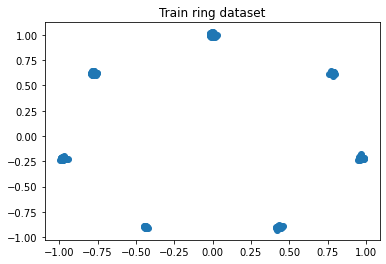

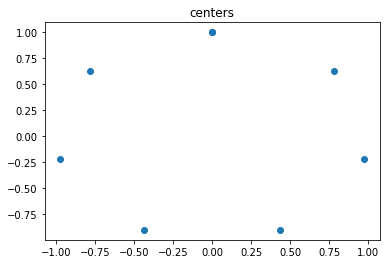

In [ ]:
plt.figure()
plt.title('Train ring dataset')
plt.scatter(train_ring_X[:,0],train_ring_X[:,1])
plt.figure()
plt.title('centers')
plt.scatter(centre_ring[:,0],centre_ring[:,1])
print("train_grid_X=\n",train_ring_X[0:5])
print("test_ring_X=\n",test_ring_X[0:5])
print("centre_ring=\n",centre_ring[0:5])

* Sample Grid Dataset

train_grid_X=
 tf.Tensor(
[[-5.04668826e-01 -5.10210207e-01]
 [-4.80543035e-01  1.50886446e-02]
 [-1.00701271e+00  8.20762358e-04]
 [-1.00839116e+00 -5.13597385e-01]
 [ 4.31138152e-03  5.13358828e-01]], shape=(5, 2), dtype=float64)
test_grid_X=
 tf.Tensor(
[[ 0.49048025 -0.99826334]
 [-0.51086789  0.48885386]
 [-0.50369684 -0.99860741]
 [ 1.02447029 -0.99539142]
 [-0.99559871 -1.00530898]], shape=(5, 2), dtype=float64)
centre_grid=
 [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]]


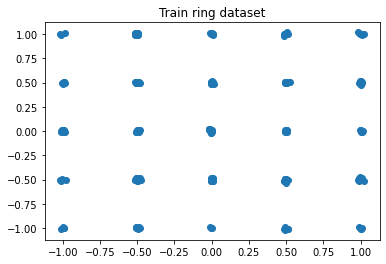

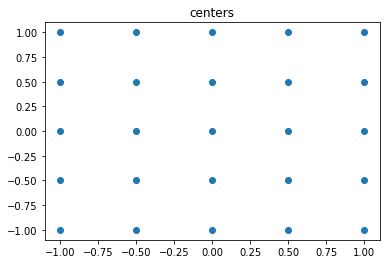

In [ ]:
train_grid_X, test_grid_X, centre_grid = sample_grid(params['batch_size'],0.8)
plt.figure()
plt.title('Train ring dataset')
plt.scatter(train_grid_X[:,0],train_grid_X[:,1])
plt.figure()
plt.title('centers')
plt.scatter(centre_grid[:,0],centre_grid[:,1])

print("train_grid_X=\n",train_grid_X[0:5])
print("test_grid_X=\n",test_grid_X[0:5])
print("centre_grid=\n",centre_grid[0:5])

### Train the two variants of GANs to generate the corresponding 2D distribution. (**4 x 10 =  40 points**)



* Ring dataset on vanilla gan

In [ ]:
loss_v_ring, g_v_ring, d_v_ring = compile_vgan(v_ring, train_ring_X)

Epoch: 1,  Generator Loss: 0.318048,  Discriminator Loss: 1.614925
Epoch: 2,  Generator Loss: 0.313273,  Discriminator Loss: 1.626563
Epoch: 3,  Generator Loss: 1.313261,  Discriminator Loss: 0.626526
Epoch: 4,  Generator Loss: 0.316206,  Discriminator Loss: 1.618508
Epoch: 5,  Generator Loss: 1.186171,  Discriminator Loss: 0.676600
Epoch: 6,  Generator Loss: 0.313262,  Discriminator Loss: 1.626548
Epoch: 7,  Generator Loss: 0.313262,  Discriminator Loss: 1.626527
Epoch: 8,  Generator Loss: 0.313263,  Discriminator Loss: 1.626521
Epoch: 9,  Generator Loss: 1.313262,  Discriminator Loss: 0.626523
Epoch: 10,  Generator Loss: 0.314105,  Discriminator Loss: 1.624159
Epoch: 11,  Generator Loss: 1.313262,  Discriminator Loss: 0.626523
Epoch: 12,  Generator Loss: 0.313262,  Discriminator Loss: 1.626523
Epoch: 13,  Generator Loss: 1.313254,  Discriminator Loss: 0.626526
Epoch: 14,  Generator Loss: 0.313262,  Discriminator Loss: 1.626523
Epoch: 15,  Generator Loss: 0.313263,  Discriminator Loss

* Ging dataset on vanilla gan

In [ ]:
loss_v_grid, g_v_grid, d_v_grid = compile_vgan(v_grid, train_grid_X)

Epoch: 1,  Generator Loss: 0.334157,  Discriminator Loss: 1.597112
Epoch: 2,  Generator Loss: 1.251865,  Discriminator Loss: 0.700263
Epoch: 3,  Generator Loss: 0.374615,  Discriminator Loss: 2.310130
Epoch: 4,  Generator Loss: 0.318158,  Discriminator Loss: 2.608379
Epoch: 5,  Generator Loss: 1.293432,  Discriminator Loss: 1.628802
Epoch: 6,  Generator Loss: 1.280327,  Discriminator Loss: 1.631454
Epoch: 7,  Generator Loss: 0.313955,  Discriminator Loss: 2.622296
Epoch: 8,  Generator Loss: 0.313327,  Discriminator Loss: 2.625571
Epoch: 9,  Generator Loss: 1.313261,  Discriminator Loss: 1.626275
Epoch: 10,  Generator Loss: 1.313262,  Discriminator Loss: 1.626444
Epoch: 11,  Generator Loss: 1.313260,  Discriminator Loss: 1.626496
Epoch: 12,  Generator Loss: 0.313278,  Discriminator Loss: 2.626469
Epoch: 13,  Generator Loss: 1.313262,  Discriminator Loss: 1.626519
Epoch: 14,  Generator Loss: 0.313267,  Discriminator Loss: 2.626507
Epoch: 15,  Generator Loss: 0.313262,  Discriminator Loss

* Ring dataset on Wasserstein gan

In [ ]:
loss_w_ring, g_w_ring, d_w_ring = compile_wgan(w_ring,train_ring_X)

Epoch: 1,  Generator Loss: 0.875260,  Discriminator Loss: 0.920616
Epoch: 2,  Generator Loss: 0.026912,  Discriminator Loss: 0.021949
Epoch: 3,  Generator Loss: 0.002138,  Discriminator Loss: 0.001818
Epoch: 4,  Generator Loss: 0.039490,  Discriminator Loss: 0.013805
Epoch: 5,  Generator Loss: 0.165299,  Discriminator Loss: 0.066642
Epoch: 6,  Generator Loss: 0.231286,  Discriminator Loss: 0.142592
Epoch: 7,  Generator Loss: 0.114762,  Discriminator Loss: 0.151262
Epoch: 8,  Generator Loss: 0.040978,  Discriminator Loss: 0.000223
Epoch: 9,  Generator Loss: 0.263549,  Discriminator Loss: 0.022586
Epoch: 10,  Generator Loss: 0.066552,  Discriminator Loss: 0.070261
Epoch: 11,  Generator Loss: 0.019351,  Discriminator Loss: 0.005131
Epoch: 12,  Generator Loss: 0.071465,  Discriminator Loss: 0.056422
Epoch: 13,  Generator Loss: 0.153436,  Discriminator Loss: 0.206260
Epoch: 14,  Generator Loss: 0.036016,  Discriminator Loss: 0.079012
Epoch: 15,  Generator Loss: 0.012113,  Discriminator Loss

* Grid dataset on Wasserstein gan

In [ ]:
loss_w_grid, g_w_grid, d_w_grid  = compile_wgan(w_grid,train_grid_X)

Epoch: 1,  Generator Loss: 0.551773,  Discriminator Loss: 0.319487
Epoch: 2,  Generator Loss: 0.009584,  Discriminator Loss: 0.015406
Epoch: 3,  Generator Loss: 0.035272,  Discriminator Loss: 0.016995
Epoch: 4,  Generator Loss: 0.003588,  Discriminator Loss: 0.005207
Epoch: 5,  Generator Loss: 0.010469,  Discriminator Loss: 0.003697
Epoch: 6,  Generator Loss: 0.183760,  Discriminator Loss: 0.063922
Epoch: 7,  Generator Loss: 0.333217,  Discriminator Loss: 0.127635
Epoch: 8,  Generator Loss: 0.000553,  Discriminator Loss: 0.001005
Epoch: 9,  Generator Loss: 0.105020,  Discriminator Loss: 0.040113
Epoch: 10,  Generator Loss: 0.000848,  Discriminator Loss: 0.004427
Epoch: 11,  Generator Loss: 0.272223,  Discriminator Loss: 0.128732
Epoch: 12,  Generator Loss: 0.307036,  Discriminator Loss: 0.097283
Epoch: 13,  Generator Loss: 0.000389,  Discriminator Loss: 0.000620
Epoch: 14,  Generator Loss: 0.093203,  Discriminator Loss: 0.036985
Epoch: 15,  Generator Loss: 0.430632,  Discriminator Loss

## Use this pretrained generator and input noise to it at the time of testing and get the generated distribution. (**4 x 5 = 20 points**)


In [ ]:
def test(gan,data):
    predicted=[]
    for i in range(len(data)):
        p = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(1)
        fake = gan.generator_model(p)
        predicted.append(fake[0])
    predicted = np.array(predicted)
    plt.figure()
    plt.title('predicted')
    plt.scatter(predicted[:,0],predicted[:,1])
    plt.figure()
    plt.title('Test ring dataset')
    plt.scatter(data[:,0],data[:,1])
    return predicted

* Generated Ring dataset on vanilla gan

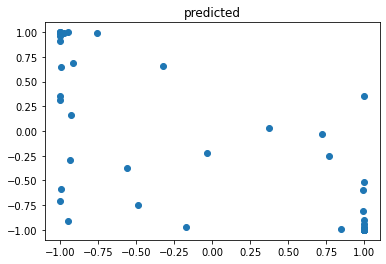

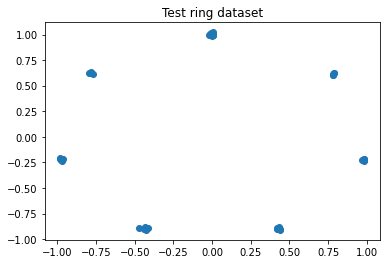

In [ ]:
v_ring_test_ring_X = test(v_ring, test_ring_X)

* Generated Grid dataset on vanilla gan

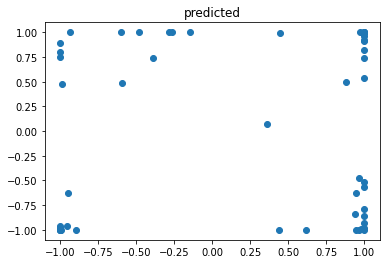

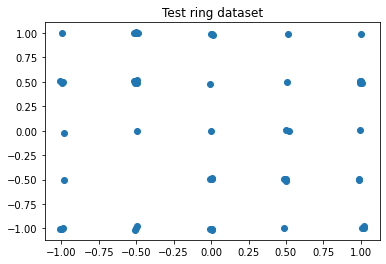

In [ ]:
v_grid_test_grid_X = test(v_grid, test_grid_X)

* Generated Ring dataset on Wasserstein gan

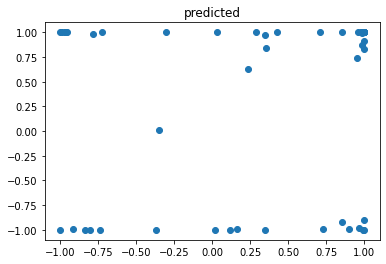

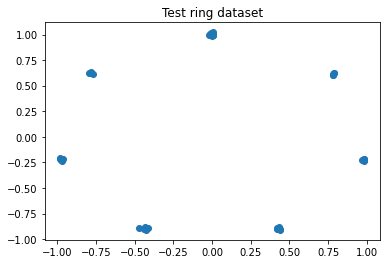

In [ ]:
w_ring_test_ring_X = test(w_ring, test_ring_X)

* Generated Grid dataset on Wasserstein gan

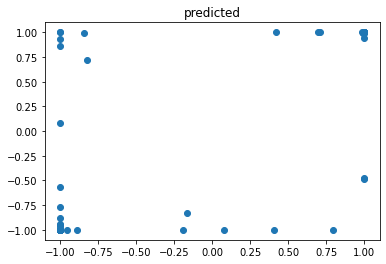

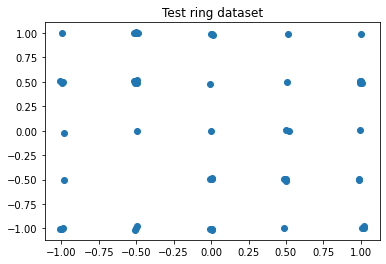

In [ ]:
w_grid_test_grid_X = test(w_grid,test_grid_X)

* Now compute the KL divergence metric between this generated distribution and the held out sampled data distribution. (**4 x 2 = 8 points**)


In [ ]:
def kl_divergence(p,q):
    l=[0]*len(p)
    m = tf.keras.metrics.KLDivergence()
    for i in range(len(p)):
        a = p[i][0]
        b = p[i][1]
        c = float(q[i][0])
        d = float(q[i][1])
        m.update_state([a,b],[c,d])
    result=m.result().numpy()
    return result
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics/KLDivergence

* Ring dataset on Vanilla gan

In [ ]:
print("Kl-diverengence = ", kl_divergence(v_ring_test_ring_X,test_ring_X))

Kl-diverengence =  7.9968467


* Grid dataset on Vanilla gan

In [ ]:
print("Kl-diverengence = ", kl_divergence(v_grid_test_grid_X,test_grid_X))

Kl-diverengence =  8.813644


* Generated Ring dataset on Wasserstein gan

In [ ]:
print("Kl-diverengence = ", kl_divergence(w_ring_test_ring_X,test_ring_X))

Kl-diverengence =  10.933747


* Generated grid dataset on Wasserstein gan

In [ ]:
print("Kl-diverengence = ", kl_divergence(w_grid_test_grid_X,test_grid_X))

Kl-diverengence =  6.024421



* Compare and contrast all the two variants of the GANs using appropriate plots. (**4 x 5 = 20 points**)


Answer: 
* I tried with different activation function for the layers and result varied a lot. Lesser is observed when i used tanh() activation function. Wasserstein gan is stable as compared to Vanilla gan. To enforce the constraint, WGAN applies a very simple clipping to restrict the maximum weight value i.e. the weights of the discriminator must be within a certain range controlled by the hyperparameters. Vanilla gan is simplest type of gan.

* Wasserstein gan has lesser loss than vanilla gan and grid dataset on vanilla dataset has maximum loss. But if we see generated data on coordinate axis, it looks grid dataset has accurate prediction than ring dataset.

In [ ]:
def plotme(total_loss, g_loss, d_loss, data):  
    a = []
    for i in range(1,len(data)+1):
        a.append(i)
    plt.figure(figsize=(10,5))
    plt.title('Vanilla Gan (total loss vs generator loss vs discriminator loss)')
    plt.xlabel("Epoch")
    plt.ylabel("loss value")
    plt.plot(a, total_loss,color='green', label="total loss" )
    plt.plot(a, g_loss, label="generator loss",color='blue')
    plt.plot(a, d_loss, label="discriminator loss", color='red')
    plt.legend()

* Generated Ring dataset on Vanilla gan

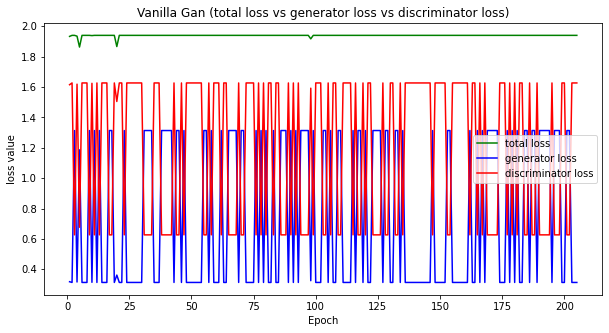

In [ ]:
plotme(loss_v_ring, g_v_ring, d_v_ring, train_ring_X)

* Generated Grid dataset on Vanilla gan

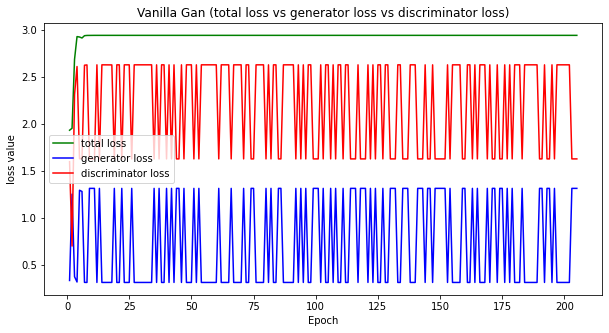

In [ ]:
plotme(loss_v_grid, g_v_grid, d_v_grid, train_ring_X)

* Generated Ring dataset on Wasserstein gan

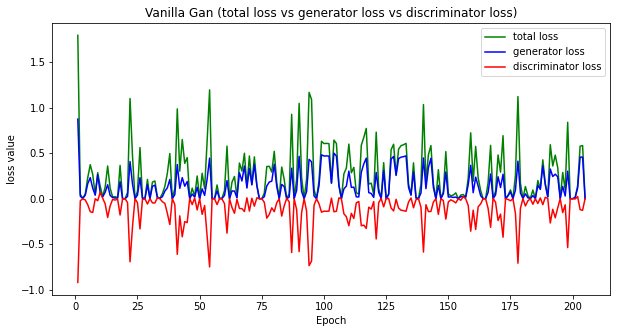

In [ ]:
plotme(loss_w_ring, g_w_ring, d_w_ring, train_ring_X)

* Generated Grid dataset on Wasserstein gan

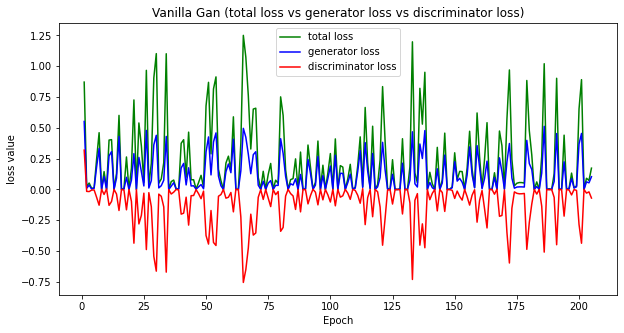

In [ ]:
plotme(loss_w_grid, g_w_grid, d_w_grid, train_ring_X)


* Based on your observations, discuss in brief the various strengths and limitations of the GAN variants in modelling the different data distributions. (**4 points**)

Answer:
* Strength: 
* It allows easy sampling of data from distribution
* It is able to model the unsupervised data where the data is not labelled
* It can generate data and could be useful where data is availabe in less amount
* It is able to produce new state of art that is not possible by other techniques like deep fake video etc
* Limitation
* It is computationally costly.
* It's techniques is difficult to understand for newbies.
* It's accuracy is high only after lots of epochs
